In [51]:
import SIMSIToolBox
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error
import random as rd
import seaborn as sb
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import spatial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.svm import SVR
cosineSim = lambda x1,x2: 1 - spatial.distance.cosine(x1, x2)
import statsmodels.api as sm
from scipy.interpolate import interp1d

In [52]:
#goal simulate labeling patterns

n=100
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
isa_func = SIMSIToolBox.arachidonicISA

gs = np.random.random(n)
gs2 = np.random.random(n)
ds = np.random.random(n)
ts = np.random.random((n,3))
ts = np.array([x/np.sum(x) for x in ts])

In [53]:
labeling_theo = []
labeling_theo2 = []
for g,g2,t,d in zip(gs,gs2,ts,ds):
    labeling_theo.append(isa_func(g,d,t,N,None))
    labeling_theo2.append(SIMSIToolBox.palmitateISA(g2,d,t,N,None))

labeling_theo = np.array(labeling_theo)
labeling_theo2 = np.array(labeling_theo2)

T = [0,0,1]


In [56]:
plt_dict = {}

for noiseFrac in np.linspace(0,.5,15):

    for g,d,t,l_true,l_true2 in zip(gs,ds,ts,labeling_theo,labeling_theo2):
        noise = np.random.random(l_true.shape)
        noise = noiseFrac * noise / np.sum(noise)
        l_obs = (1-noiseFrac) * l_true / np.sum(l_true)
        l_obs = [l+ns for l,ns in zip(l_obs,noise)]
        l_obs = np.array(l_obs)/np.sum(l_obs)
        
        noise = np.random.random(l_true2.shape)
        noise = noiseFrac * noise / np.sum(noise)
        l_obs2 = (1-noiseFrac) * l_true2 / np.sum(l_true2)
        l_obs2 = [l+ns for l,ns in zip(l_obs2,noise)]
        l_obs2 = np.array(l_obs2)/np.sum(l_obs2)
                
        err_measure = np.sum([np.abs(x-y) for x,y in zip(l_obs,l_true)])

        
        _, _, x_pred, err, _ = SIMSIToolBox.ISAFit(T,N,l_obs2,SIMSIToolBox.palmitateISA,list(range(len(l_obs2))),.5)
        
        g_pred, _, _, err, l_pred = SIMSIToolBox.ISAFit_knownT(x_pred,N,l_obs,isa_func,list(range(len(l_obs))),.5)
        
        g_pred = g_pred[0]
        
        g_class, _, _, err, l_pred = SIMSIToolBox.ISAFit_classical(T,N,l_obs,isa_func,list(range(len(l_obs))),np.array([.5,.5]))

        if g_pred > -.0001 and g_pred < 1.1 and all(xx > -0.01 and xx < 1.1 for xx in x_pred) and g_class > -.0001 and g_class < 1.1:
            plt_dict[len(plt_dict)] = {"method":"SISA","error in g(t)":np.abs(g-g_pred),"measurement error":err_measure}
            plt_dict[len(plt_dict)] = {"method":"Classical ISA","error in g(t)":np.abs(g-g_class),"measurement error":err_measure}
plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
plt_dict

,method,error in g(t),measurement error
0,SISA,0.000012,2.611318e-16
1,Classical ISA,0.032560,2.611318e-16
2,SISA,0.000006,0.000000e+00
3,Classical ISA,0.181737,0.000000e+00
4,SISA,0.000156,2.294460e-16
...,...,...,...
2563,Classical ISA,0.419633,7.757883e-01
2564,SISA,0.137059,8.190952e-01
2565,Classical ISA,0.076059,8.190952e-01
2566,SISA,0.414937,8.840262e-01


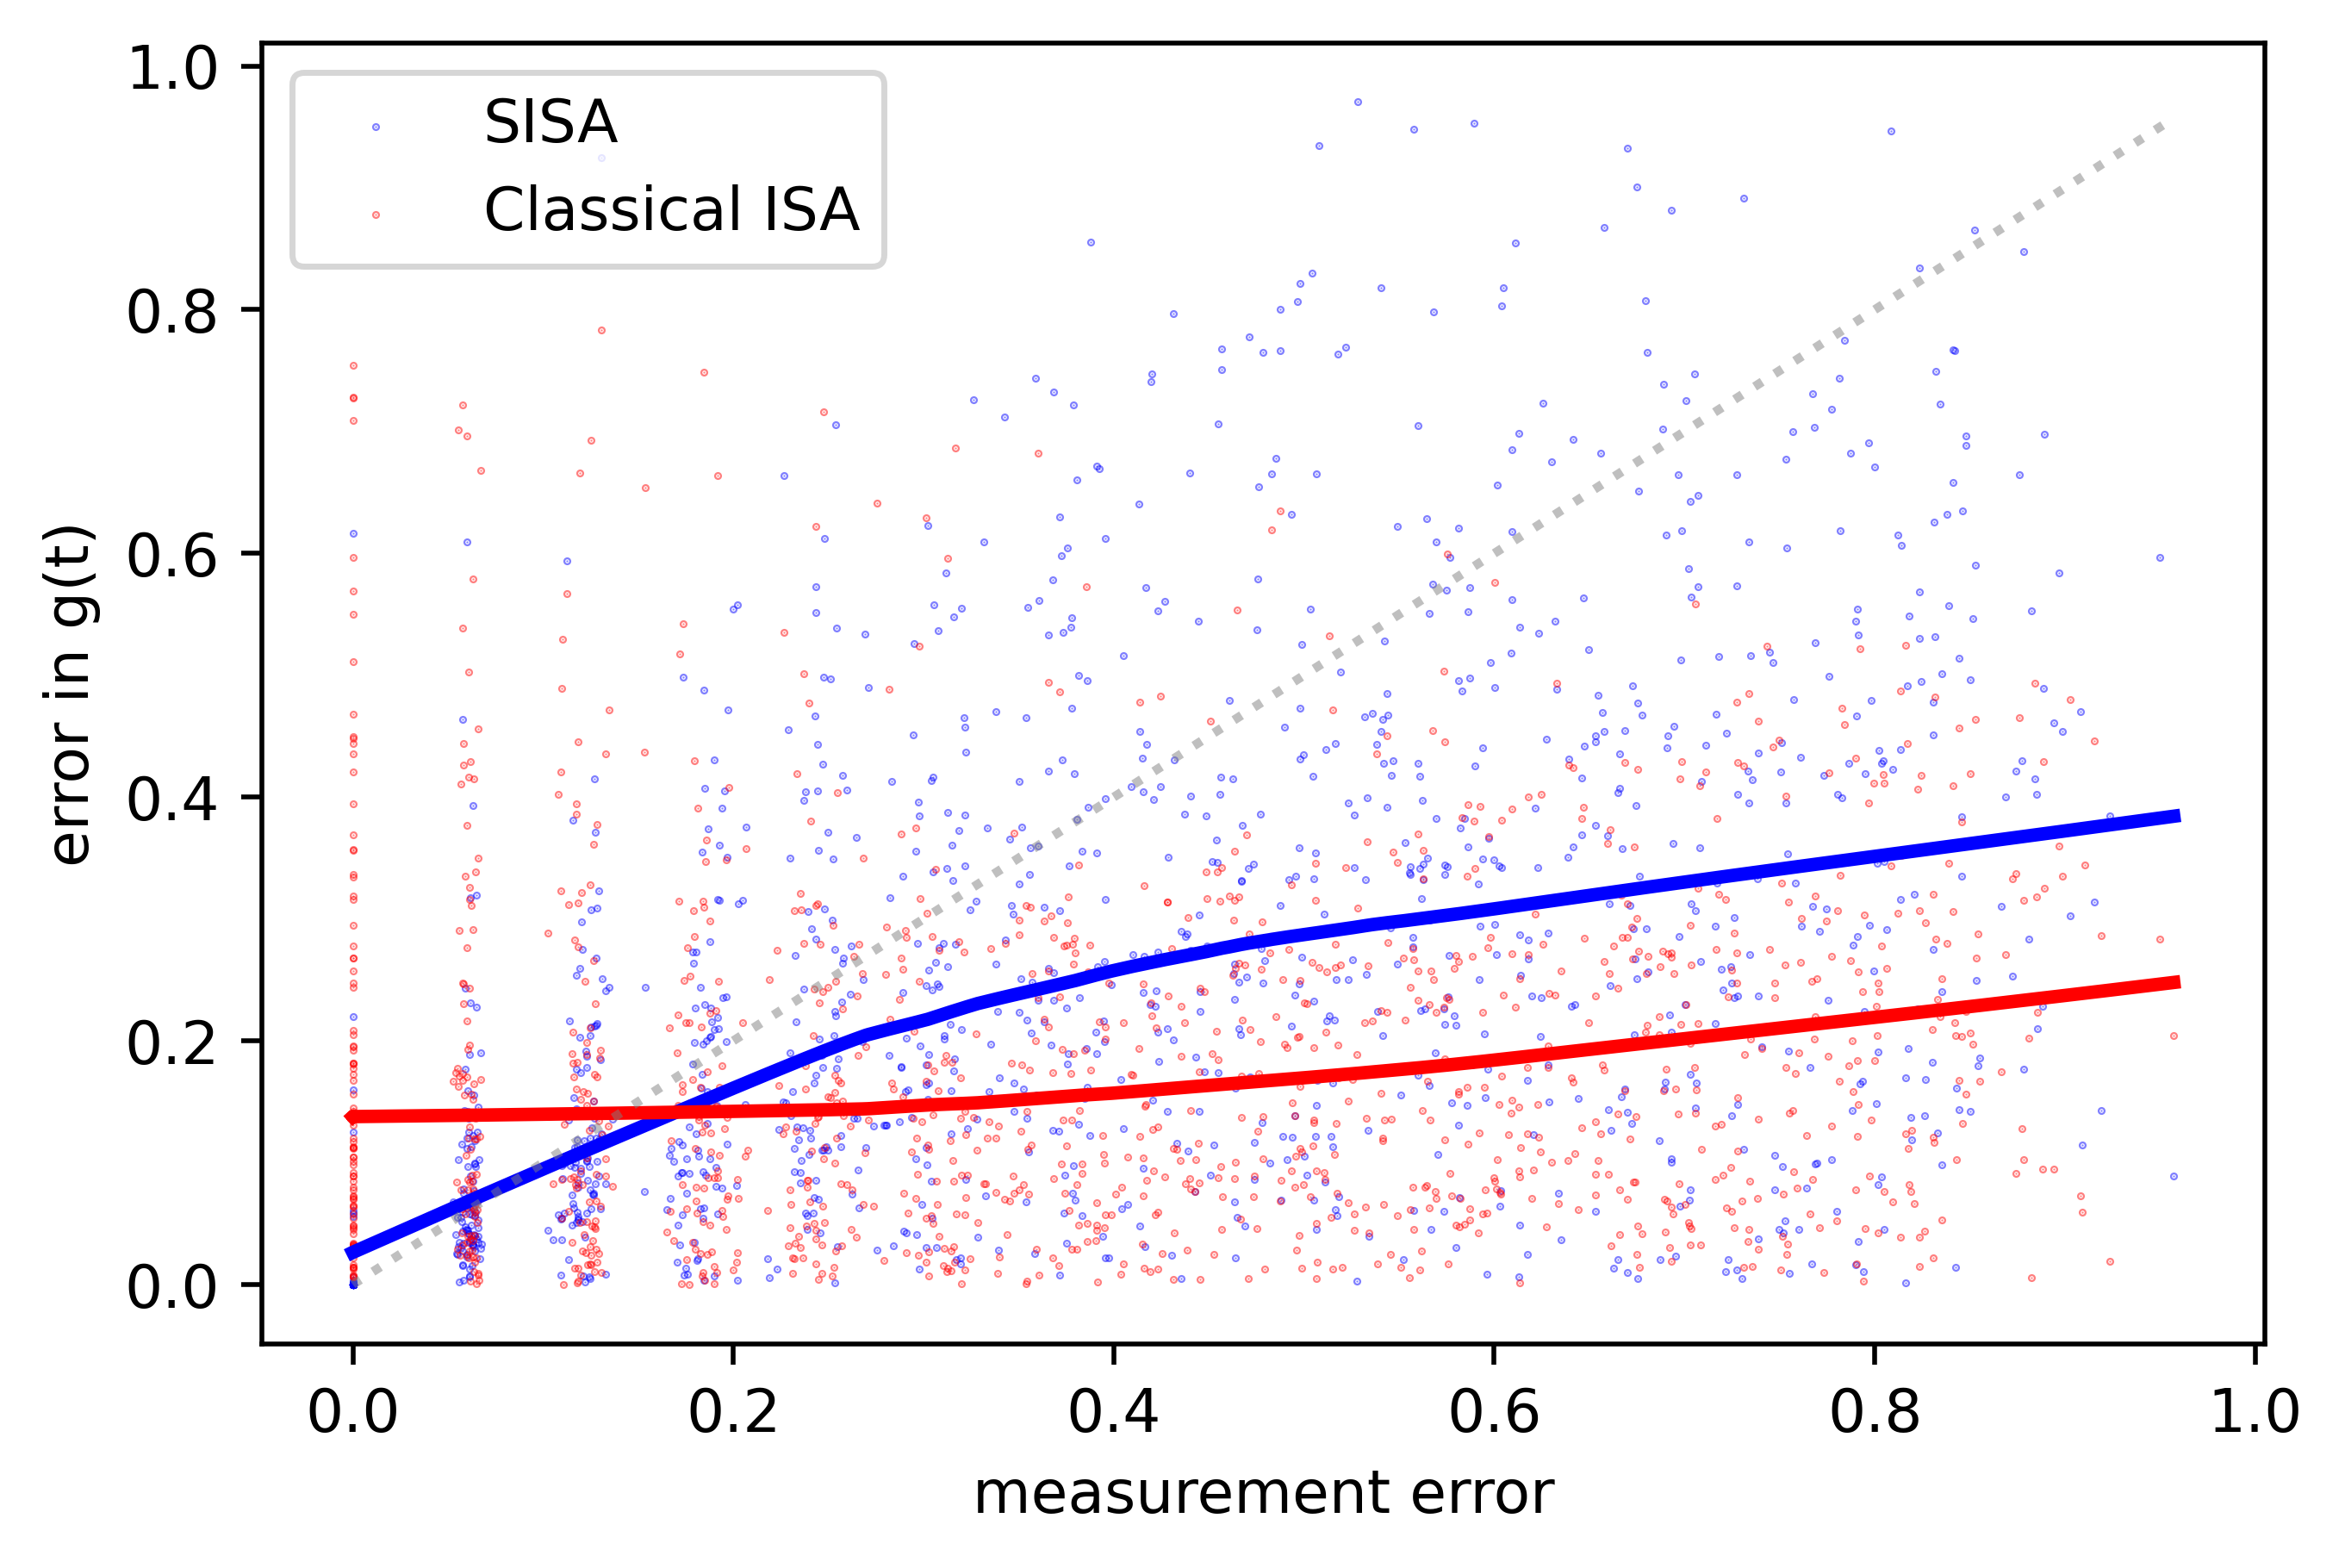

In [71]:
palette = {"SISA":"blue","Classical ISA":"red"}
models = {}
#sb.lineplot(data=plt_dict,x="measurement error",y="error in g(t)",hue="method",palette=palette)
for method,color in palette.items():
    filt = plt_dict[plt_dict["method"] == method]
    sb.regplot(data=plt_dict[plt_dict["method"] == method],x="measurement error",y="error in g(t)",lowess=True, ci=95,scatter_kws={"s": .1,"alpha":0.5},color=color,label=method)
    lowess = sm.nonparametric.lowess
    z = lowess(filt["error in g(t)"].values, filt["measurement error"].values,is_sorted=False)
    models[method] = interp1d(z[:,0],z[:,1],fill_value="extrapolate")

plt.legend()
plt.plot(z[:,0],z[:,0],alpha=0.5,color="grey",linestyle=":")

In [7]:
formula = "C20H31O2" 
polarity="negative"
num_cores=10
ppmThresh = 50
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/subset_data/"
file = "20201027_01_110w170h_12CnontumorLiver7_02116B_01 02116B_1.csv"
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(formula,elementOfInterest="C")
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=0)
df = pd.read_csv(datadir + file,index_col=0)
msi.from_pandas(df,polarity)

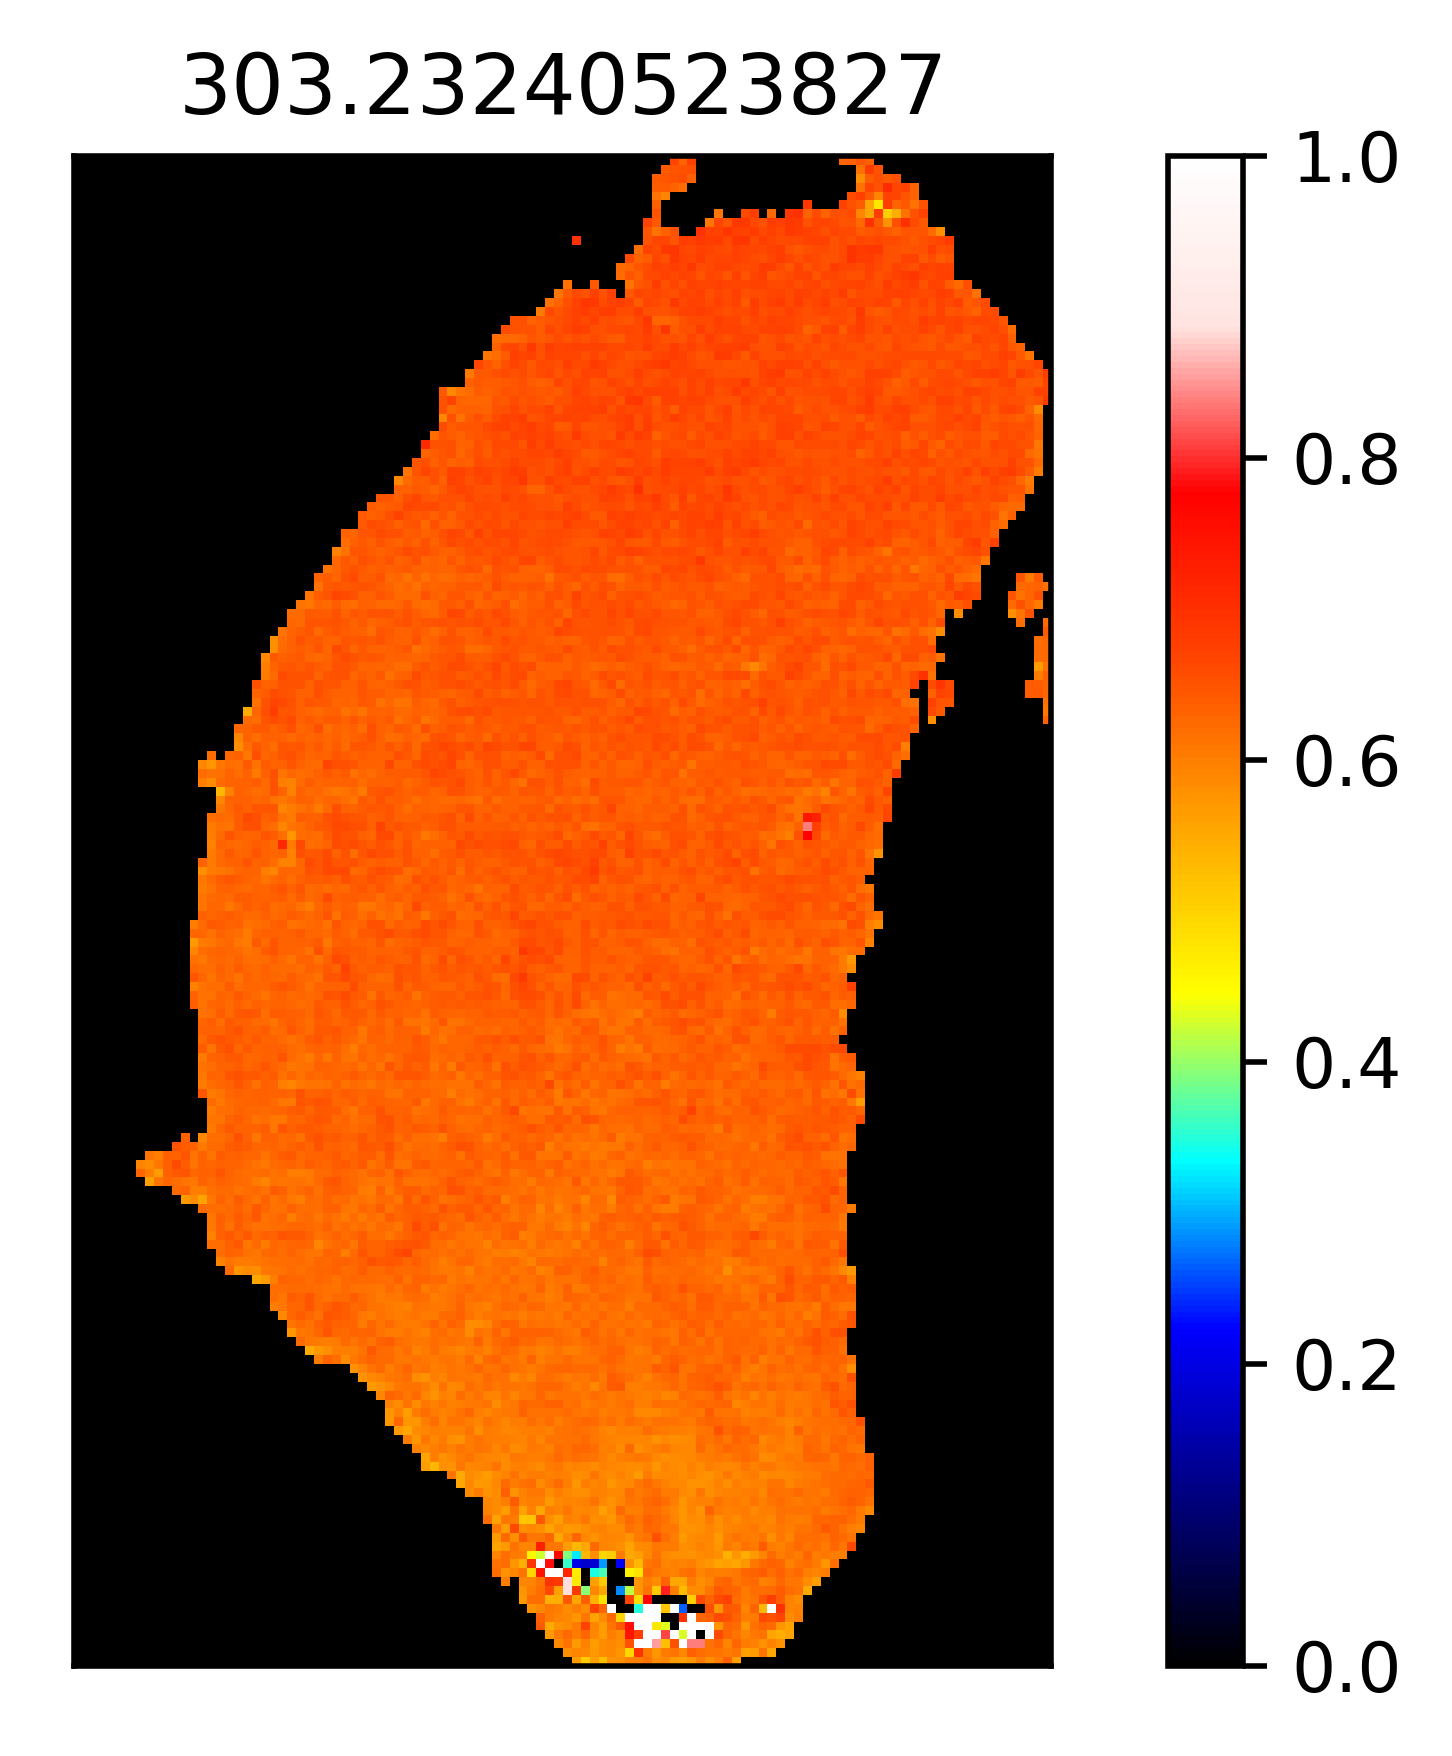

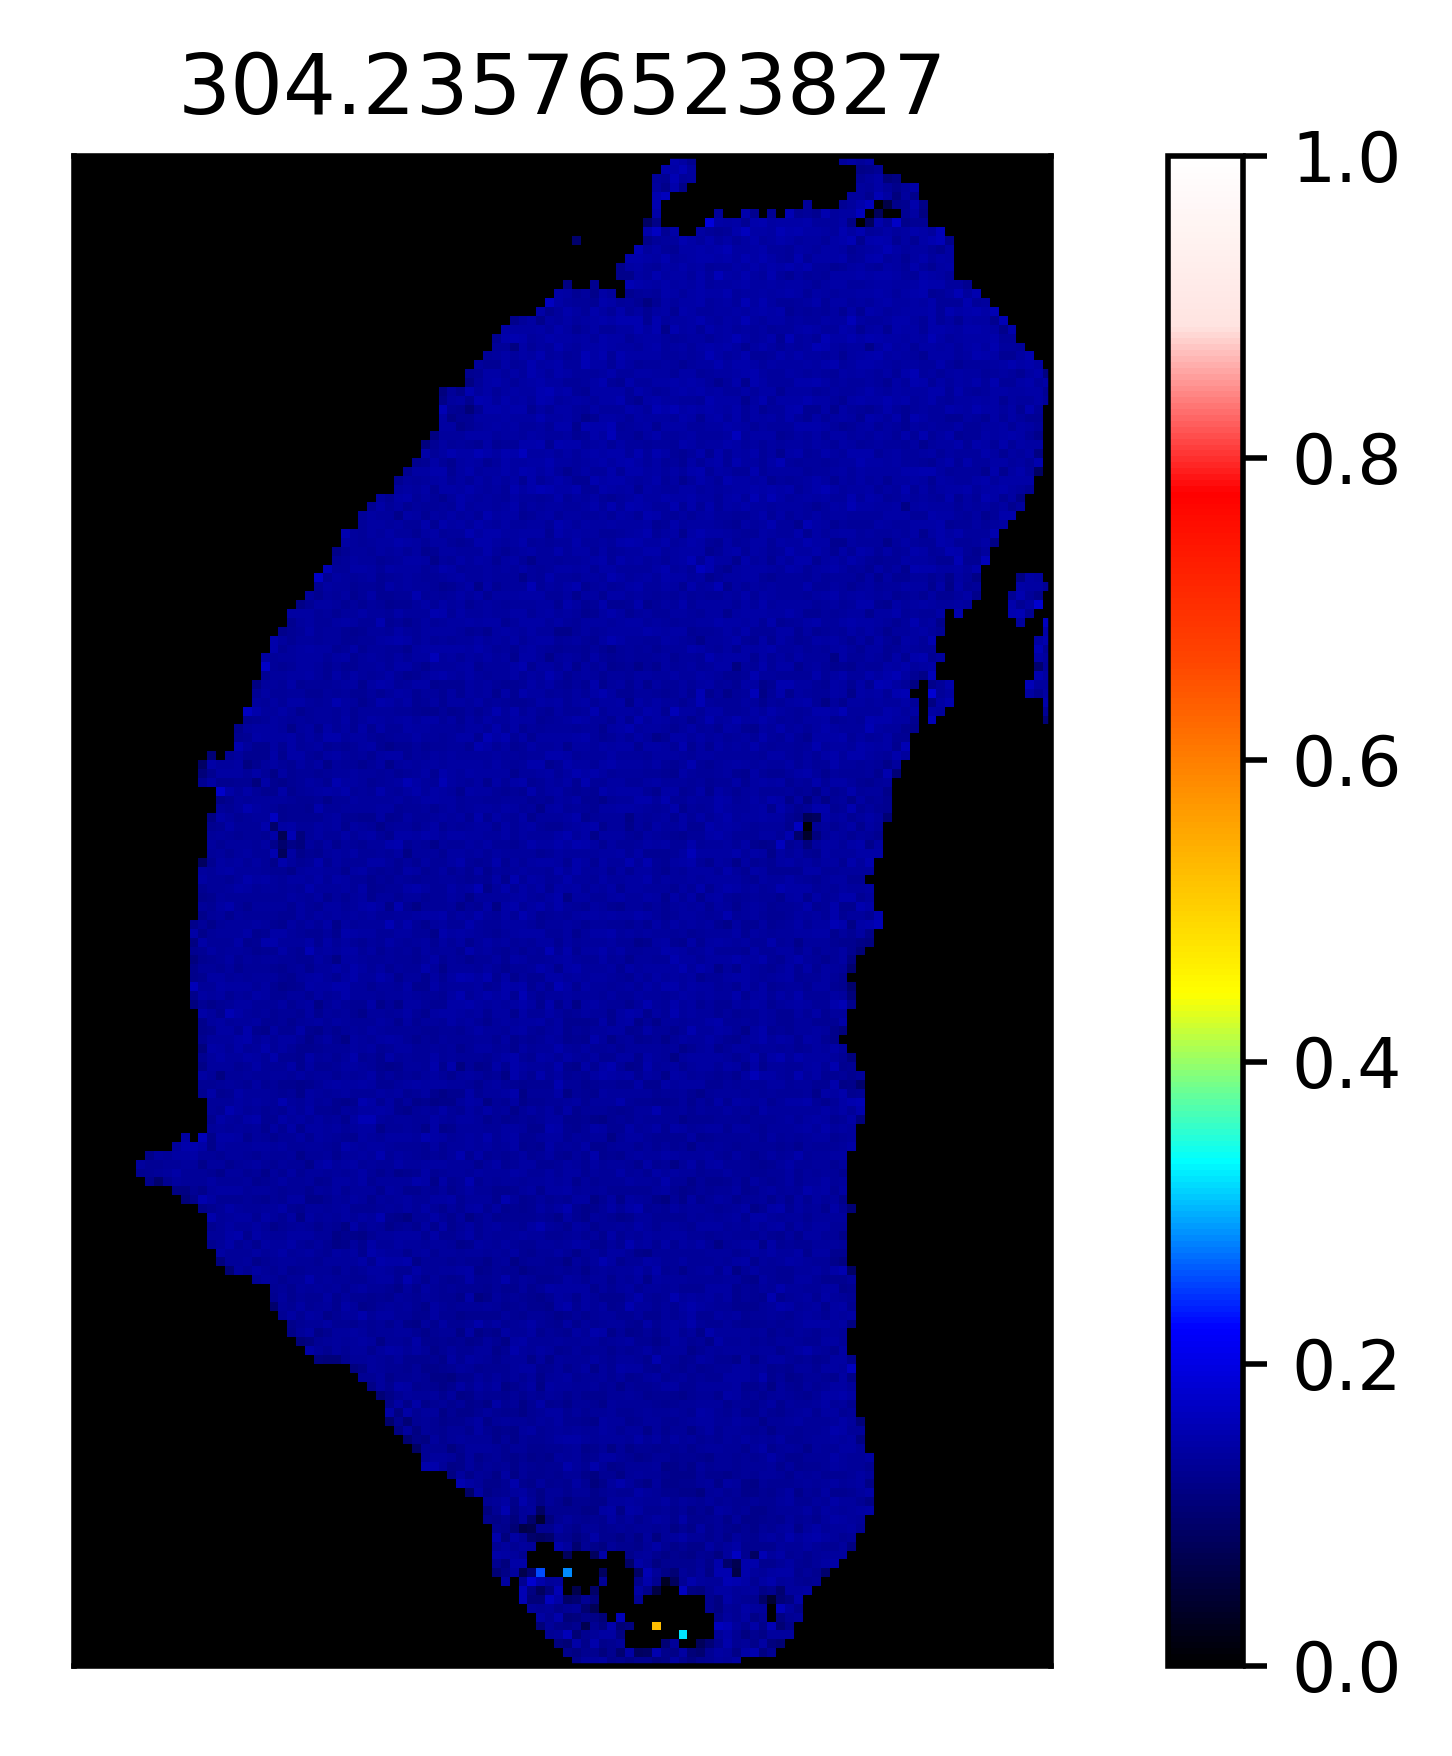

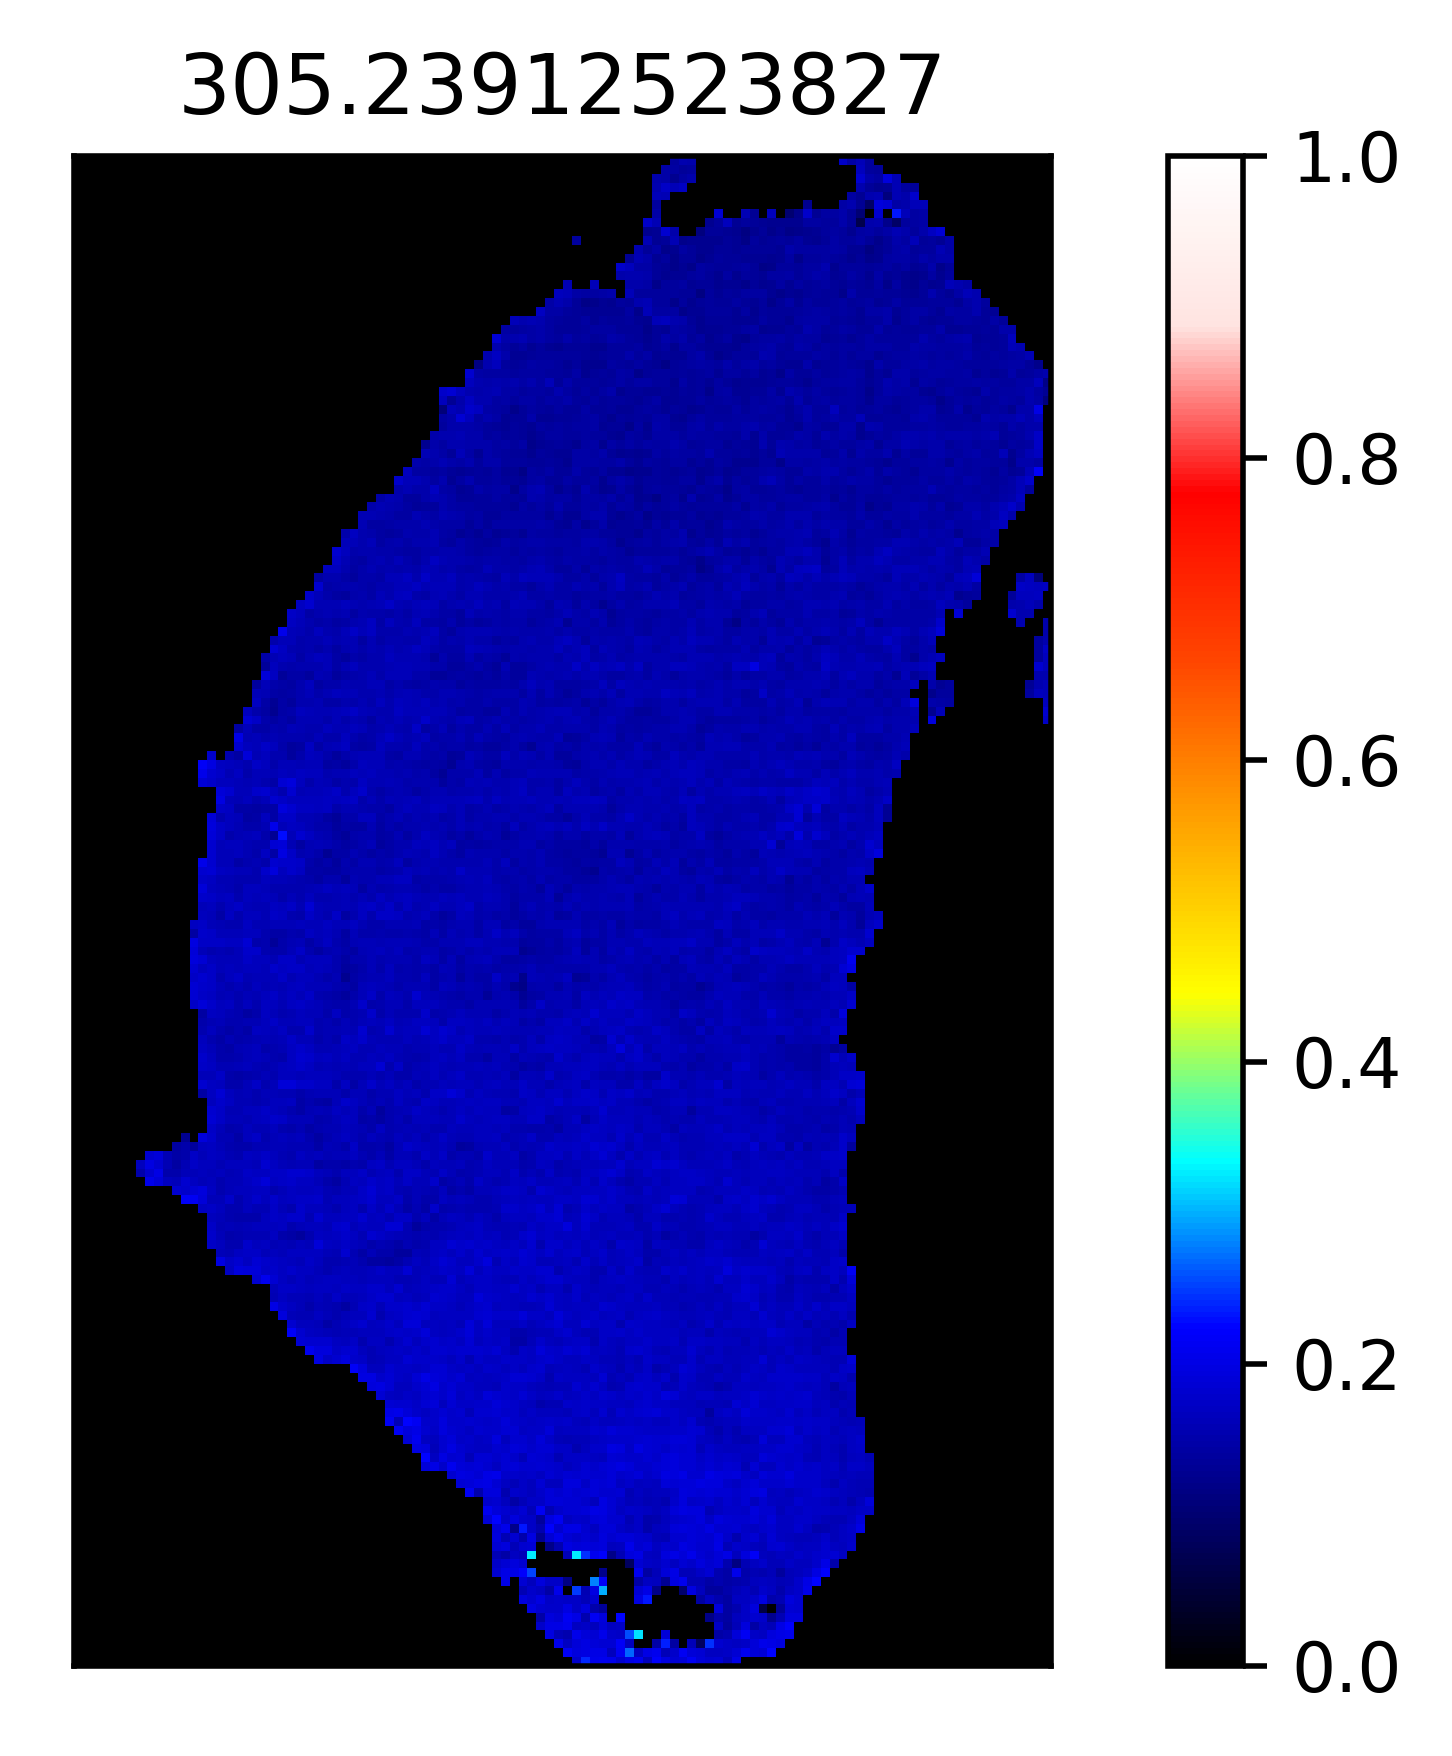

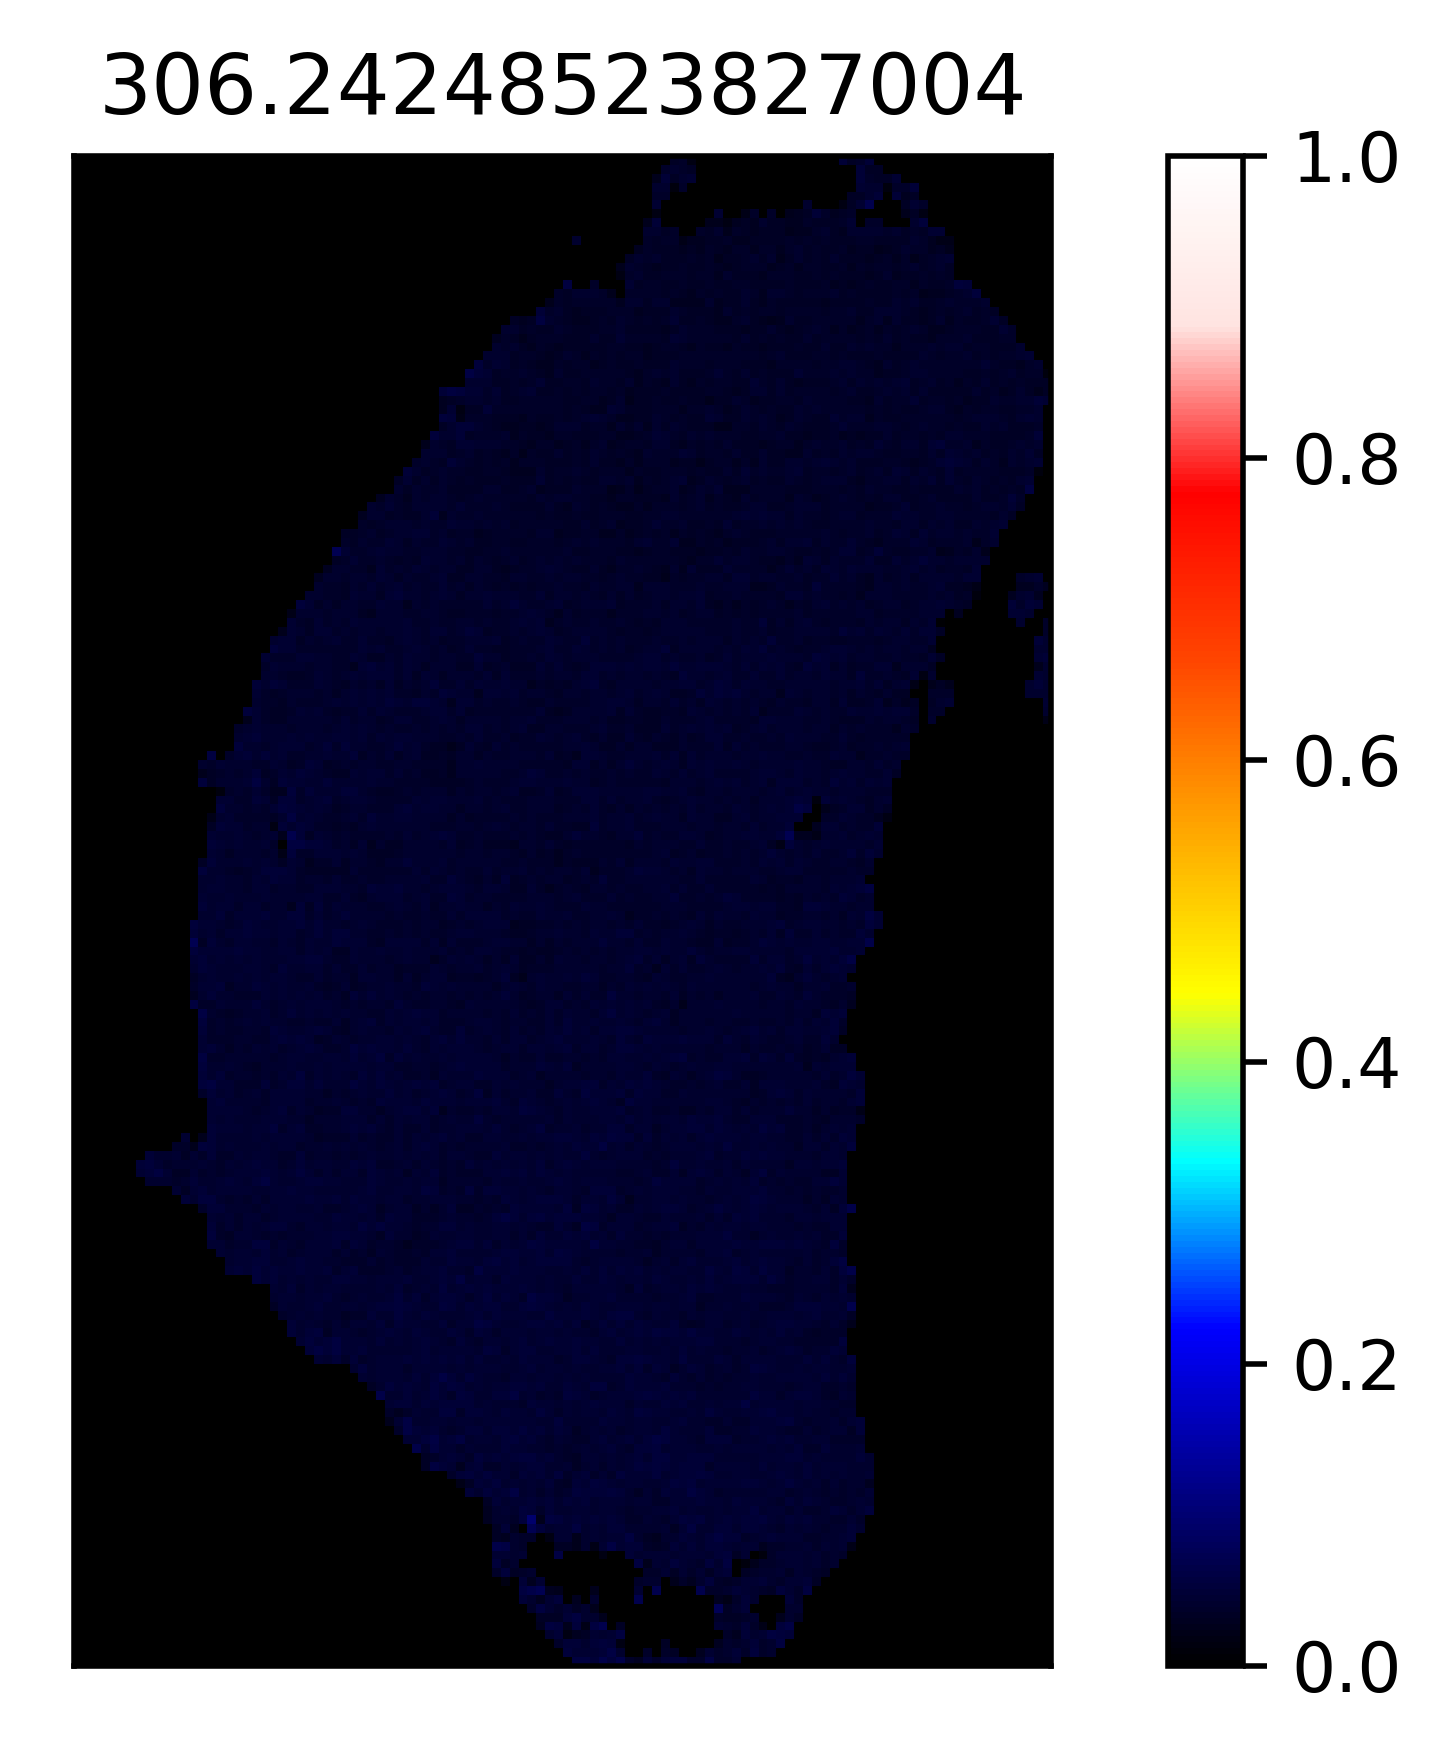

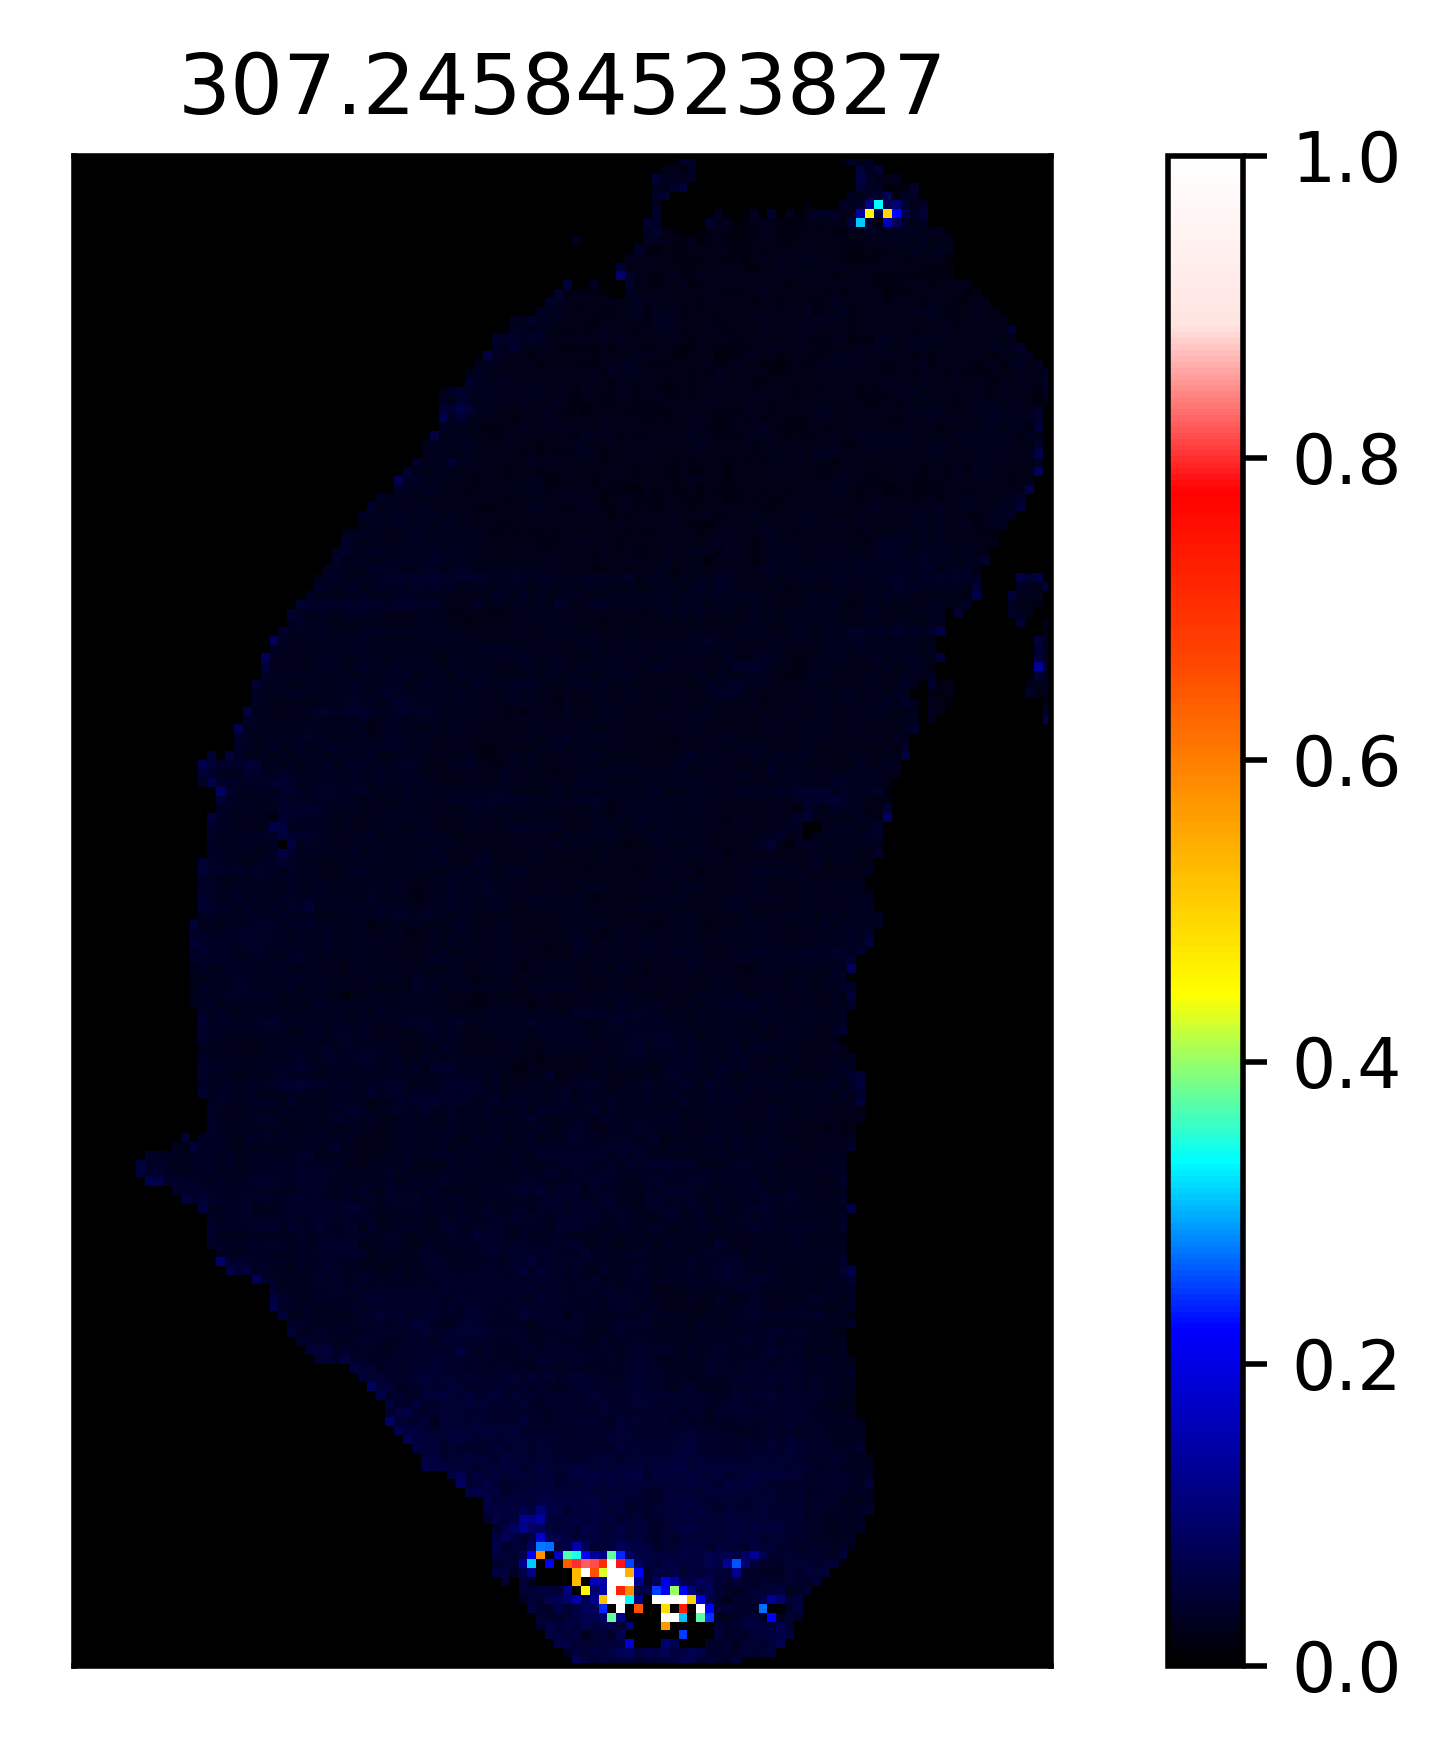

In [73]:
#calculation labeling pattern images and save result
goodInds = [x for x in range(len(msi.data_tensor)) if x in [0,1,2,3,4]]

iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor[goodInds])
colormap = LinearSegmentedColormap.from_list("test",colors=["black", "navy","blue","cyan","yellow","orange","orangered","red","mistyrose","white"],N=256)

for mz,image in zip(np.array(msi.targets)[goodInds],iso_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.clim(0,1.0)
    plt.title(mz)



In [63]:
patterns = []
for row in range(iso_tensor.shape[1]):
    for col in range(iso_tensor.shape[2]):
        if msi.imageBoundary[row,col] > 0.5:
            patterns.append(iso_tensor[:,row,col])
print(len(patterns))

10589


In [64]:
truePattern = np.array(isa_func(1.0,0.0,T,N,None))[goodInds]
print(truePattern)

[0.80154117 0.17830036 0.00125724]


Text(0, 0.5, '# of pixels')

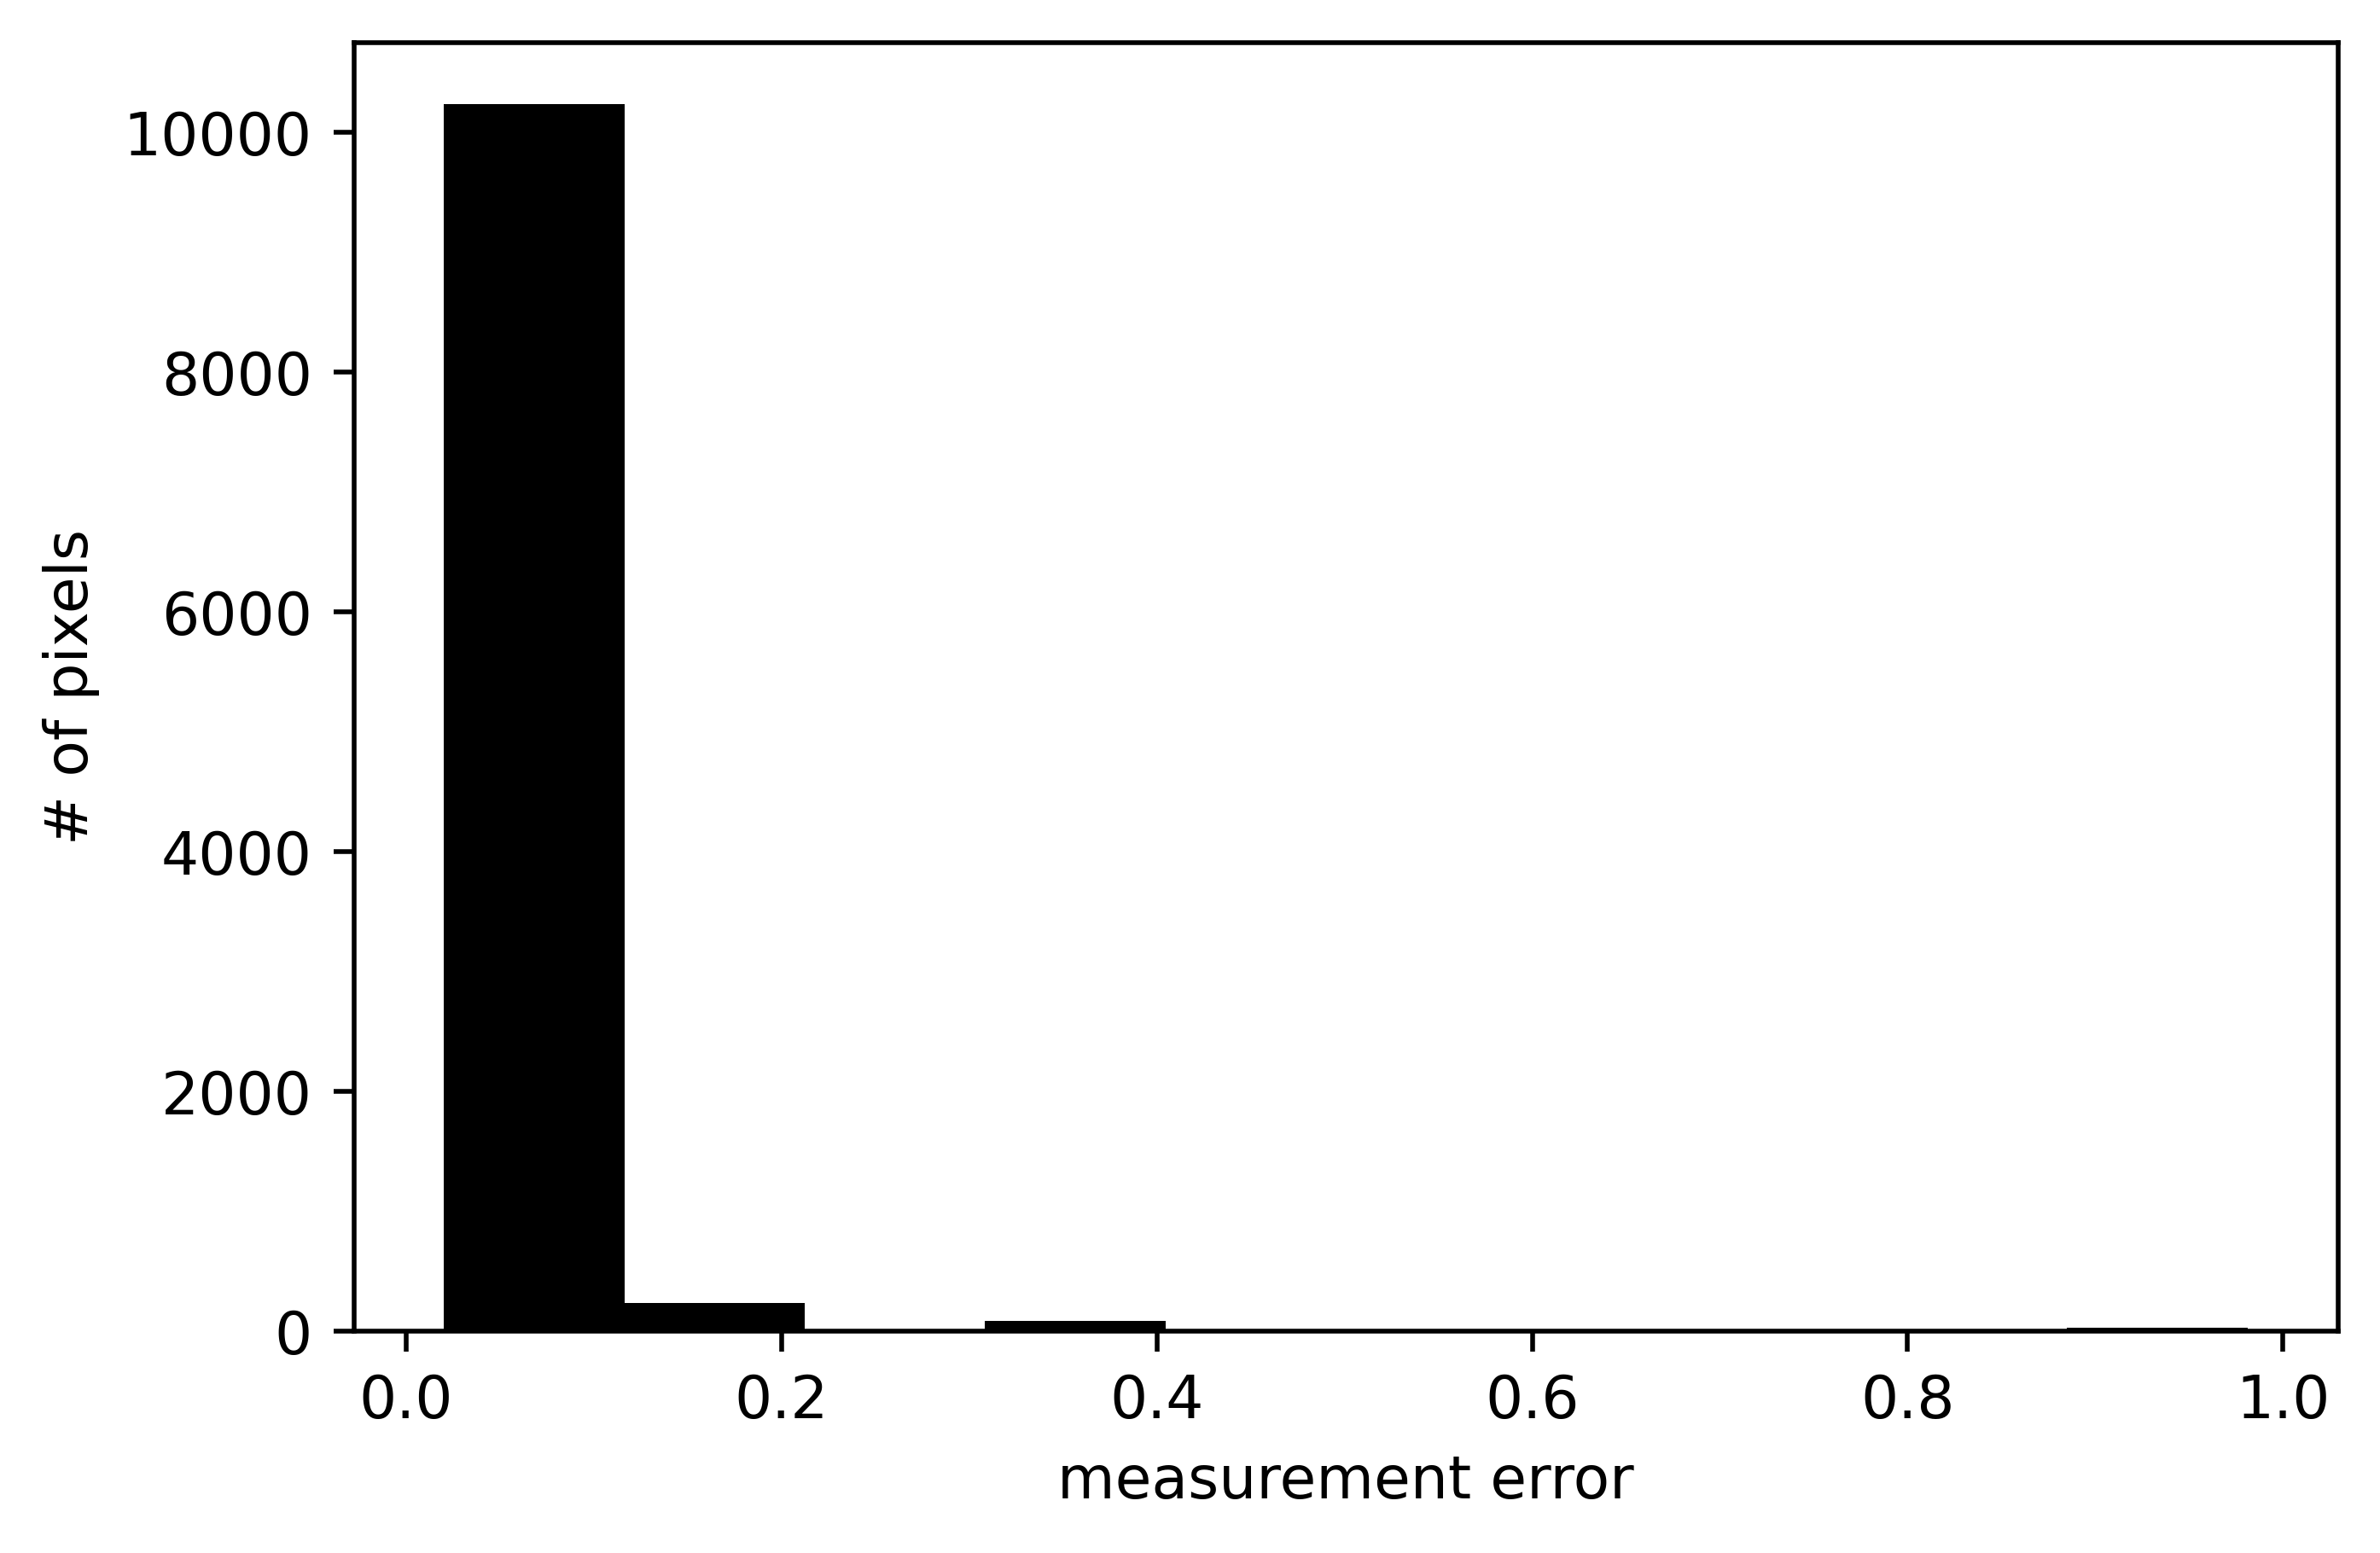

In [68]:
errs = []
for pattern in patterns:
    err_measure = np.sum([np.abs(x-y) for x,y in zip(pattern,truePattern)])
    errs.append(err_measure)
plt.hist(errs,color="black")
plt.xlabel("measurement error")
plt.ylabel("# of pixels")


Text(0, 0.5, '# of pixels')

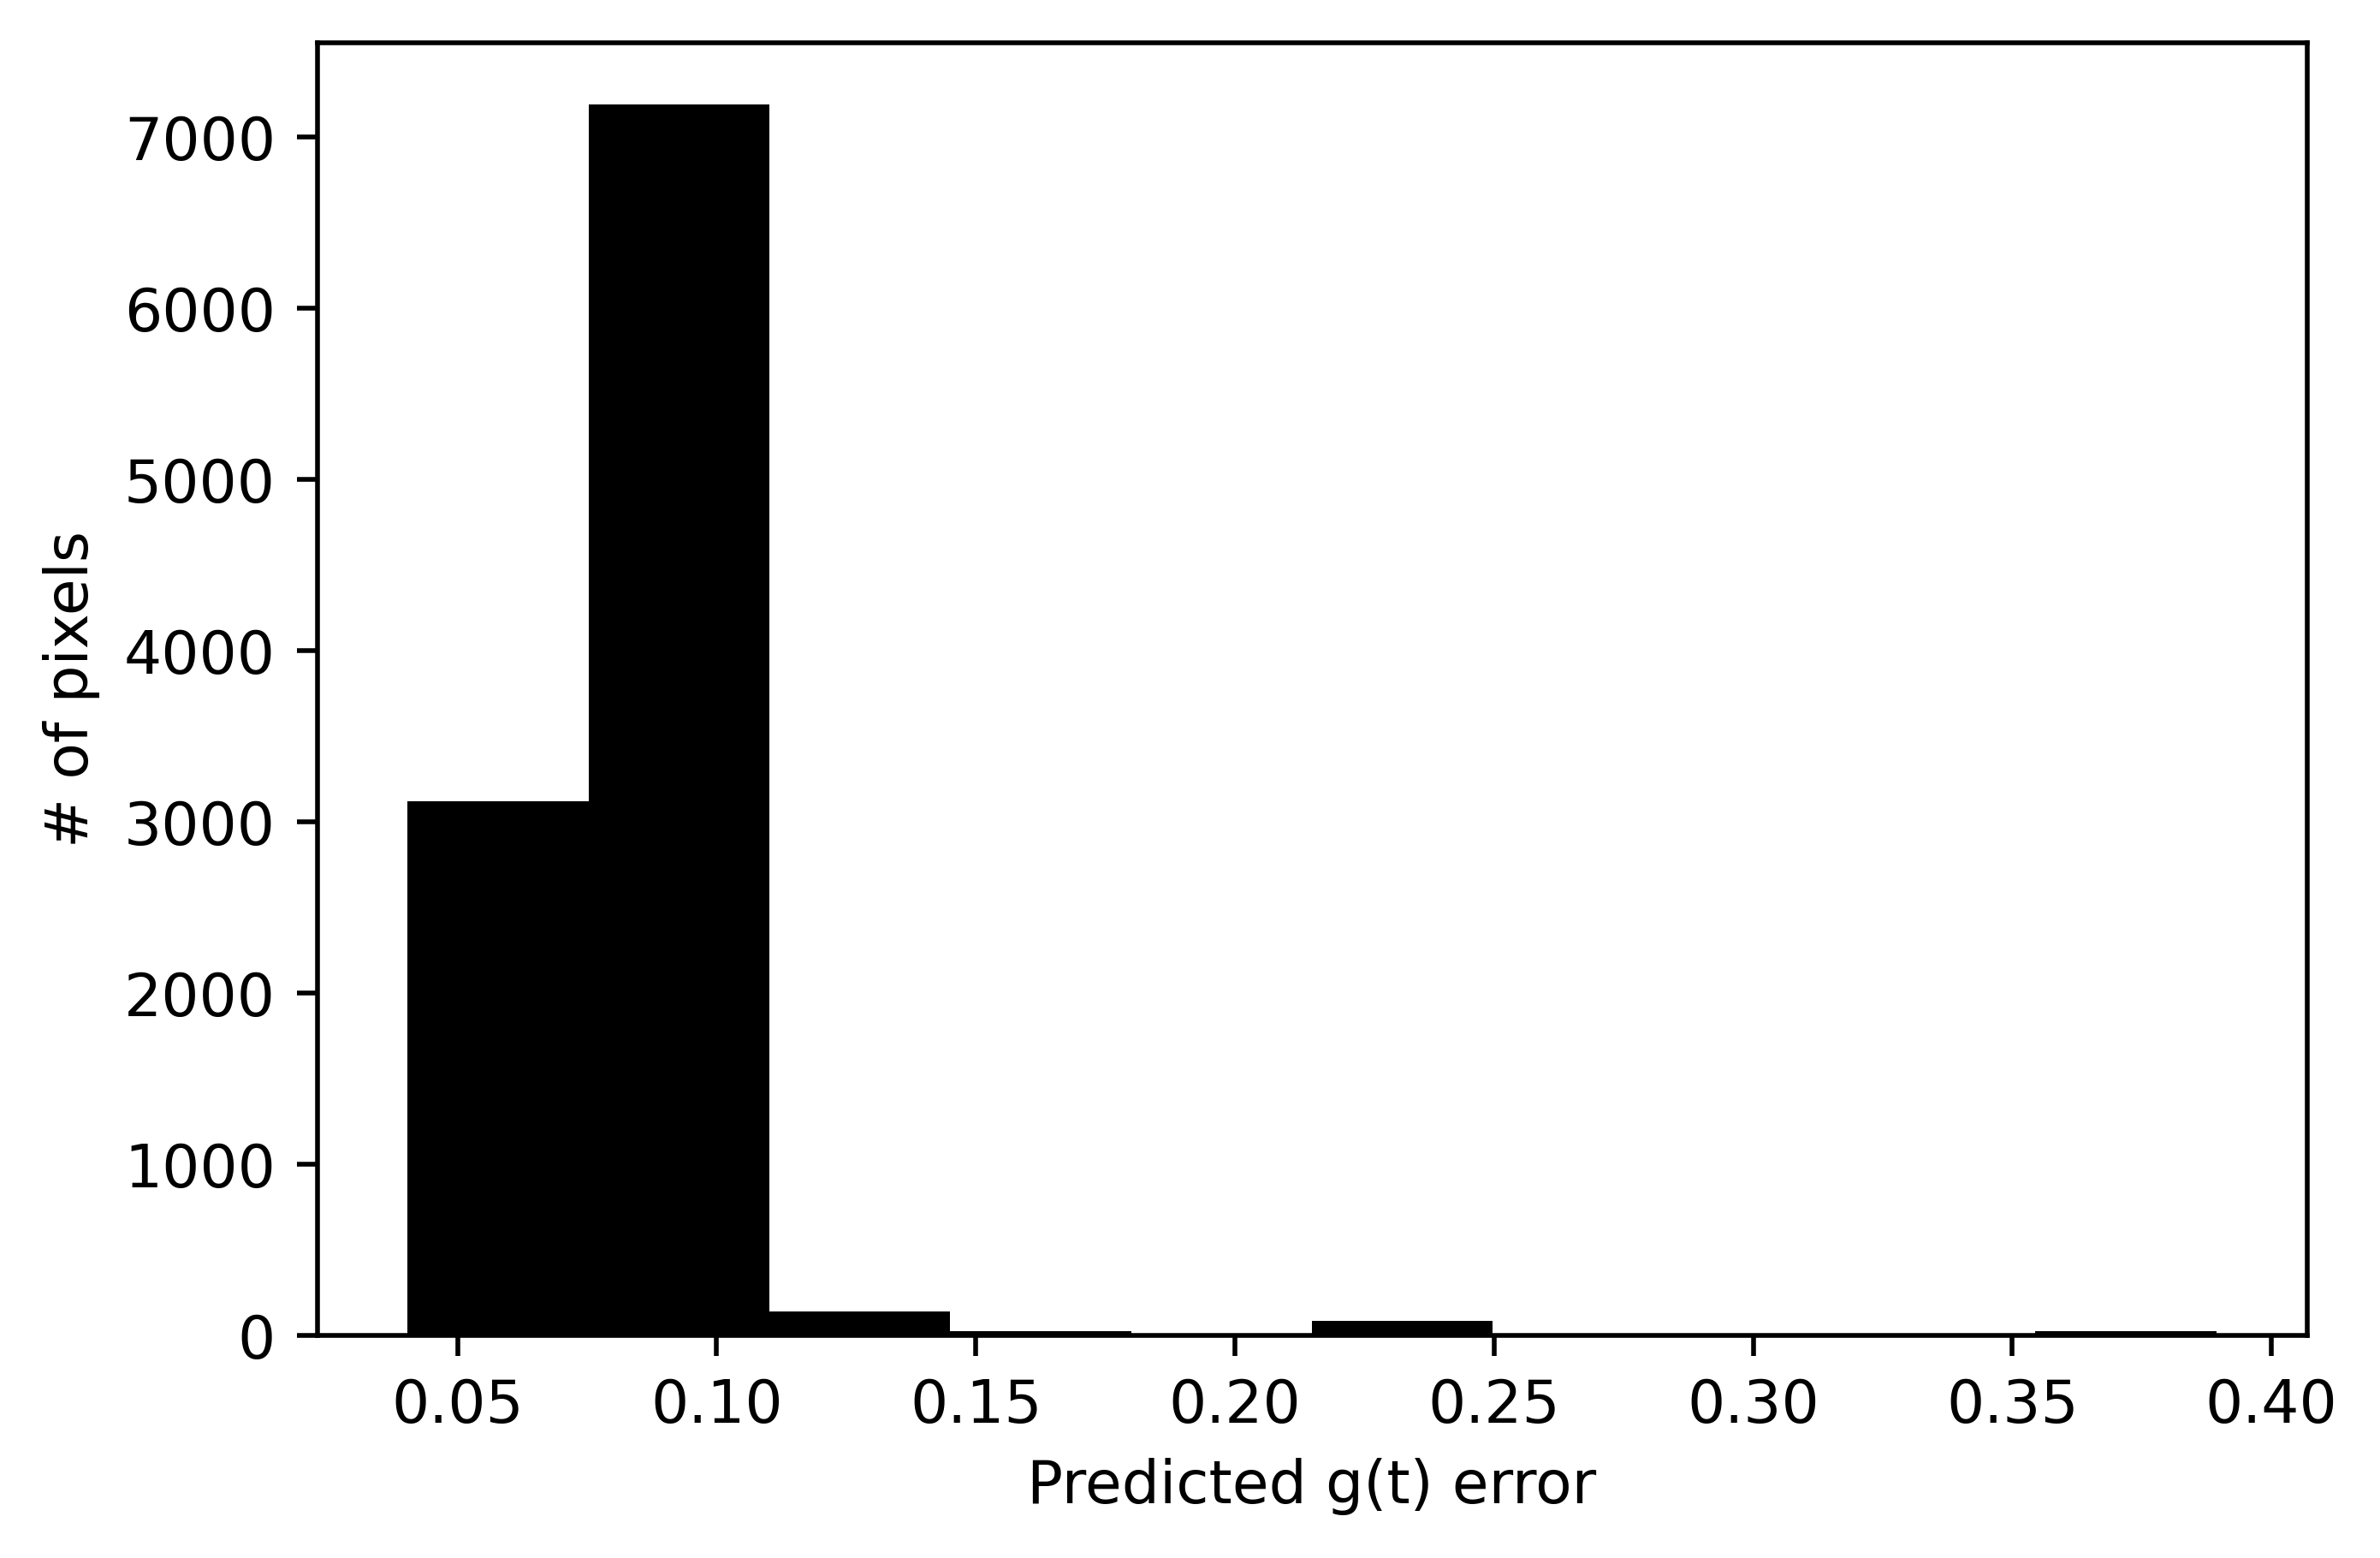

In [69]:
gerrs = []
for err in errs:
    gerrs.append(models["SISA"](err).tolist())
plt.hist(gerrs,color="black")
plt.xlabel("Predicted g(t) error")
plt.ylabel("# of pixels")


In [23]:
patterns[30]

array([0.65014085, 0.14768075, 0.12867606, 0.04135211, 0.03215023])

In [13]:
0.14/0.66452904

0.21067551840924817